In [1]:
# Automatically reload changes to external code
%load_ext autoreload
%autoreload 2



In [2]:
import tensorflow as tf
from mnist import loader #loader for mnist dataset
from matplotlib import pyplot as plt
from tensorflow.python.ops import rnn
import numpy as np
import pdb, time

# Mnist dataset

The MNIST database of handwritten digits. [[website]](http://yann.lecun.com/exdb/mnist/)<br>
There are **60,000** training images and **10,000** testing images in this dataset.<br>
Each digit is a one-channel image. Size of image = 28*28 = 784.

![](imgs/mnist_ex.png)

There are some build-in mnist function can be used in tensorflow.

Ex.<br>
from tensorflow.examples.tutorials.mnist import input_data<br>
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instead of using these functions, I'll use the orginal dataset manually in this code.<br>
It's more clear to trace the data-processing.

When we load the data


In [3]:
# load mnist data manually
# loading 'train' or 'test' data
# ex. load_mnist_data('train')
# return images, labels and mean of all images. (But, we'll only use the mean of training data.)
# ims: [N * 784]
# labels: [N]
# ims_mean: [784]

def load_mnist_data(flag, data_path='data'):
    data_loader = loader.MNIST(data_path)
    if flag == 'train':
        ims, labels = data_loader.load_training()
    elif flag == 'test':
        ims, labels = data_loader.load_testing()
    else:
        raise ValueError("Error. Only training or testing data.")
    ims = ims/255.0
    ims_mean = np.mean(ims, axis=0)
    ims = np.reshape(ims, [len(ims),28,28])
    ims_mean = np.reshape(ims_mean,(28,28))
    return ims, labels, ims_mean

In [4]:
# Parameters
learning_rate = 0.01
training_epochs = 1
batch_size = 100   # training batch size
test_batch_size = 100
display_step = 50  # testing 

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)
stddev=0.01    # standard deviation for random initialization

# Functions of Recurrent Neural Network

In [31]:
def RNN():
    rnn_cell = tf.nn.rnn_cell
    # tf Graph input
    x = tf.placeholder("float", [None, n_steps, n_input])  # mnist input images, [batch_size x 28 x 28]
    y = tf.placeholder(tf.int32,[None])              # label, [batch_size]
    # Declare Variables 
    # Store layers weight & bias
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Initial zero state
    state = lstm_cell.zero_state(batch_size, tf.float32)
    for i in range(n_steps):
        # Get lstm cell output
        with tf.variable_scope('lstm', reuse=True if i > 0 else None):
            output, state = lstm_cell(x[:,i,:], state)
    
    pred = tf.matmul(output, weights['out']) + biases['out']

    probs = tf.nn.softmax(pred)
    log_probs = tf.log(probs + 1e-8)

    one_hot_y = tf.one_hot(y, n_classes, on_value=1, off_value=0, axis=-1)
    #print one_hot_y.get_shape()
    #cross_entropy_loss = - tf.mul(y,log_probs)
    cross_entropy_loss = - tf.multiply(tf.cast(one_hot_y, tf.float32),log_probs)
    
    loss = tf.reduce_sum(cross_entropy_loss)
    


    return x, y, loss, pred, one_hot_y


In [27]:
def eval_model(sess, x, y, ims, labels, ims_test, labels_test, ims_mean, iter_per_epoch, test_iter):
    Train_Loss = 0
    Test_Loss = 0
    Train_Acc = 0
    Test_Acc = 0
    for idx in xrange(iter_per_epoch):
        batch_xs = ims[order_list[idx*batch_size:(idx+1)*batch_size]] - ims_mean
        batch_ys = labels[order_list[idx*batch_size:(idx+1)*batch_size]]
        C, A = sess.run([cost, accuracy], feed_dict={x: batch_xs, y: batch_ys})
        Train_Loss += C/batch_size   # calculate the loss in average (per image).
        Train_Acc += A
    # Eval testing dataset
    for idx in xrange(test_iter):
        batch_xs = ims_test[order_list[idx*test_batch_size:(idx+1)*test_batch_size]] - ims_mean
        batch_ys = labels_test[order_list[idx*test_batch_size:(idx+1)*test_batch_size]]
        C, A = sess.run([cost, accuracy], feed_dict={x: batch_xs, y: batch_ys})
        Test_Loss += C/test_batch_size
        Test_Acc += A
    return Train_Loss, Train_Acc, Test_Loss, Test_Acc

# Main function



Instructions for updating:
Use `tf.global_variables_initializer` instead.
------After Random Initialization------
Training: loss=2.548789, acc=0.157283.		Testing: loss=2.536077, acc=0.162200
 6.732644 seconds
------Start Training------
Epoch 0.000000, Training: loss=2.276403, acc=0.294050.		Testing: loss=2.274047, acc=0.297300
Epoch 0.083333, Training: loss=0.542239, acc=0.828167.		Testing: loss=0.527062, acc=0.836800
Epoch 0.166667, Training: loss=0.339373, acc=0.894167.		Testing: loss=0.338311, acc=0.893000
Epoch 0.250000, Training: loss=0.254496, acc=0.922950.		Testing: loss=0.247378, acc=0.924100
Epoch 0.333333, Training: loss=0.200234, acc=0.937950.		Testing: loss=0.186873, acc=0.940900
Epoch 0.416667, Training: loss=0.154682, acc=0.952333.		Testing: loss=0.154590, acc=0.950500
Epoch 0.500000, Training: loss=0.191085, acc=0.943417.		Testing: loss=0.189160, acc=0.940500
Epoch 0.583333, Training: loss=0.124252, acc=0.962167.		Testing: loss=0.129015, acc=0.959200
Epoch 0.666667, Trai

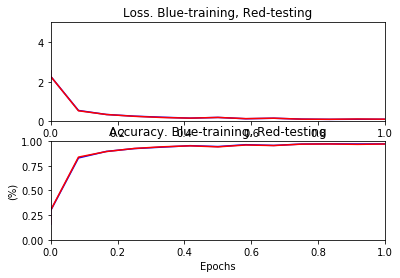

In [32]:
# loading training and testing data
ims, labels, ims_mean = load_mnist_data('train', data_path='MNIST_data')
#ims_mean = np.zeros((28*28))
ims_test, labels_test, _ = load_mnist_data('test', data_path='MNIST_data')

order_list = range(len(ims))

# parameters related to mnist dataset 
test_iter = len(ims_test)/test_batch_size # number of testing-minibatch.

iter_per_epoch = len(ims)/batch_size      # number of training-minibatch.

# Launch the graph
with tf.Session() as sess:

    # Keep training until reach max iterations
    x, y, cost, pred, one_hot_y = RNN()
    train_loss = cost/batch_size # loss per image
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(train_loss)


    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(one_hot_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


    # initialize all variables
    try:
        init = tf.initialize_all_variables()
    except:
        init = tf.global_variables_initializer()
    sess.run(init)
    Loss_plt = {'x':[], 'train_y':[], 'test_y':[]}
    Acc_plt  = {'x':[], 'train_y':[], 'test_y':[]} 
    # Before Training (Random initialization), Evaluate the model one-time.
    begin = time.time()
    Train_Loss, Train_Acc, Test_Loss, Test_Acc=eval_model(sess, x, y, ims, labels, ims_test, labels_test, ims_mean, iter_per_epoch, test_iter)
    print "------After Random Initialization------"
    print "Training: loss=%f, acc=%f.\t\tTesting: loss=%f, acc=%f" %(Train_Loss/iter_per_epoch, Train_Acc/iter_per_epoch,
                                                                     Test_Loss/test_iter, Test_Acc/test_iter)
    
    epoch = 0
    step = 0      
    
    Loss_plt['x'].append(float(step)/iter_per_epoch)
    Loss_plt['train_y'].append(Train_Loss/iter_per_epoch)
    Loss_plt['test_y'].append(Test_Loss/test_iter)
    Acc_plt['x'].append(float(step)/iter_per_epoch)
    Acc_plt['train_y'].append(Train_Acc/iter_per_epoch)
    Acc_plt['test_y'].append(Test_Acc/test_iter)
    
    duration = time.time()-begin
    print " %f seconds"%(duration)
    
    print "------Start Training------"

    for epoch in xrange(training_epochs):
        begin = time.time()
        Train_Loss = 0
        Test_Loss = 0
        Train_Acc = 0
        Test_Acc = 0
        for idx in xrange(iter_per_epoch):
            batch_xs = ims[order_list[idx*batch_size:(idx+1)*batch_size]] - ims_mean
            batch_ys = labels[order_list[idx*batch_size:(idx+1)*batch_size]]
            # Run optimization op (backprop)
            sess.run([optimizer], feed_dict={x: batch_xs, y: batch_ys})
            if step % display_step == 0:
                Train_Loss, Train_Acc, Test_Loss, Test_Acc=eval_model(sess, x, y, ims, labels, ims_test, labels_test, ims_mean, iter_per_epoch, test_iter)
                print "Epoch %f, Training: loss=%f, acc=%f.\t\tTesting: loss=%f, acc=%f"%(float(step)/iter_per_epoch, Train_Loss/iter_per_epoch, Train_Acc/iter_per_epoch, 
                                                                                         Test_Loss/test_iter, Test_Acc/test_iter)
                Loss_plt['x'].append(float(step)/iter_per_epoch)
                Loss_plt['train_y'].append(Train_Loss/iter_per_epoch)
                Loss_plt['test_y'].append(Test_Loss/test_iter)
                Acc_plt['x'].append(float(step)/iter_per_epoch)
                Acc_plt['train_y'].append(Train_Acc/iter_per_epoch)
                Acc_plt['test_y'].append(Test_Acc/test_iter)
            step += 1
        
        # Evaluate after each epoch finished.
        Train_Loss, Train_Acc, Test_Loss, Test_Acc=eval_model(sess, x, y, ims, labels, ims_test, labels_test, ims_mean, iter_per_epoch, test_iter)
        print "Epoch %d, Training: loss=%f, acc=%f.\t\tTesting: loss=%f, acc=%f"%(epoch+1, Train_Loss/iter_per_epoch, Train_Acc/iter_per_epoch, 
                                                                                         Test_Loss/test_iter, Test_Acc/test_iter)
        Loss_plt['x'].append(float(step)/iter_per_epoch)
        Loss_plt['train_y'].append(Train_Loss/iter_per_epoch)
        Loss_plt['test_y'].append(Test_Loss/test_iter)
        Acc_plt['x'].append(float(step)/iter_per_epoch)
        Acc_plt['train_y'].append(Train_Acc/iter_per_epoch)
        Acc_plt['test_y'].append(Test_Acc/test_iter)
        duration = time.time()-begin
        print "Cost %f seconds"%(duration)
    print("Optimization Finished!")
    plt.figure(1)
    plt.subplot(211)
    plt.title('Loss. Blue-training, Red-testing')
    plt.xlabel('Epochs')
    plt.axis([0, training_epochs, 0, 5.0])
    plt.plot(Loss_plt['x'], Loss_plt['train_y'], 'b-',Loss_plt['x'], Loss_plt['test_y'], 'r-')
    plt.subplot(212)
    plt.title('Accuracy. Blue-training, Red-testing')
    plt.xlabel('Epochs')
    plt.ylabel('(%)')
    plt.axis([0, training_epochs, 0, 1.0])
    plt.plot(Acc_plt['x'], Acc_plt['train_y'], 'b-', Acc_plt['x'], Acc_plt['test_y'], 'r-')
    plt.show()
 